In [8]:
# Import Data
import pandas as pd
import numpy as np

new_used_car = pd.read_csv("../data/processed_used_car.csv")
random_state = 42

y = new_used_car['sales_price_log']
# X = new_used_car.drop(['price', 'sales_price_log','model'], axis=1)     # Multivariate Imputation
X = new_used_car.drop(['price', 'sales_price_log', 'model', 'int_col', 'ext_col'], axis=1)   # XGB
print(X.shape)

(4009, 12)


In [9]:
# Data types of features
for column in X.columns:
    print(f"Column: {column}, Data Type: {new_used_car[column].dtype}")

Column: brand, Data Type: object
Column: model_year, Data Type: int64
Column: milage, Data Type: int64
Column: fuel_type, Data Type: object
Column: accident, Data Type: object
Column: clean_title, Data Type: object
Column: horsepower, Data Type: float64
Column: displacement, Data Type: float64
Column: cylinders, Data Type: float64
Column: turbo, Data Type: bool
Column: transmission_type, Data Type: object
Column: gears, Data Type: float64


In [10]:
# Inspect Missing Values
perc_missing_per_ftr = new_used_car.isnull().sum(axis=0)/new_used_car.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(new_used_car[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(new_used_car.isnull().sum(axis=1)!=0)/new_used_car.shape[0]
print('fraction of points with missing values:',frac_missing)

fraction of missing values in features:
fuel_type            0.054128
accident             0.028187
clean_title          0.148666
horsepower           0.201547
displacement         0.054128
cylinders            0.109753
transmission_type    0.121976
gears                0.457221
dtype: float64
data types of the features with missing values:
fuel_type             object
accident              object
clean_title           object
horsepower           float64
displacement         float64
cylinders            float64
transmission_type     object
gears                float64
dtype: object
fraction of points with missing values: 0.6083811424295336


In [11]:
# Group features into numerical and categorical variables
num_ftrs = ['model_year', 'milage', 'horsepower', 'displacement', 'cylinders', 'turbo', 'gears']
# cat_ftrs = ['brand', 'fuel_type', 'ext_col', 'int_col', 'accident', 'clean_title', 'transmission_type']     # Multivariate Imputation
cat_ftrs = ['brand', 'fuel_type', 'accident', 'clean_title', 'transmission_type']     # XGB

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Preprocess
# one-hot encoder for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# standard scaler for numerical variables
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

In [ ]:
import pandas as pd

def report_missing_values(df_other, df_test):
    """
    Reports the proportion of missing values per feature and per row for
    training, validation, test, and combined datasets.

    Args:
        df_train: The preprocessed training set as a DataFrame.
        df_val: The preprocessed validation set as a DataFrame.
        df_test: The preprocessed test set as a DataFrame.

    Returns:
        A dictionary with missing value statistics for training, validation,
        test, and combined datasets.
    """
    # Combine datasets
    df_combined = pd.concat([df_other, df_test], ignore_index=True)

    # Helper function to calculate missing value statistics
    def calculate_missing_stats(df, name):
        perc_missing_per_ftr = df.isnull().sum(axis=0) / df.shape[0]
        frac_missing_rows = (df.isnull().sum(axis=1) != 0).mean()
        return {
            'feature_missing_proportion': perc_missing_per_ftr[perc_missing_per_ftr > 0],
            'row_missing_proportion': frac_missing_rows
        }

    # Calculate missing value statistics
    missing_stats = {
        'training': calculate_missing_stats(df_other, 'Training'),
        'test': calculate_missing_stats(df_test, 'Test'),
        'combined': calculate_missing_stats(df_combined, 'Combined')
    }

    # Print results
    for dataset, stats in missing_stats.items():
        print(f"\n{dataset.capitalize()} Dataset:")
        print(f"Proportion of missing values per feature:")
        print(stats['feature_missing_proportion'])
        print(f"Proportion of rows with missing values: {stats['row_missing_proportion']:.4f}")



Training Dataset:
Proportion of missing values per feature:
num__horsepower      0.197381
num__displacement    0.050514
num__cylinders       0.106330
num__gears           0.455254
dtype: float64
Proportion of rows with missing values: 0.5893

Test Dataset:
Proportion of missing values per feature:
num__horsepower      0.218204
num__displacement    0.068579
num__cylinders       0.123441
num__gears           0.465087
dtype: float64
Proportion of rows with missing values: 0.6209

Combined Dataset:
Proportion of missing values per feature:
num__horsepower      0.201547
num__displacement    0.054128
num__cylinders       0.109753
num__gears           0.457221
dtype: float64
Proportion of rows with missing values: 0.5957


*Missing Value Imputation*

In [58]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

def multivariate_imputer(X_other, X_test, random_state=42):
    """
    Constructs a multivariate imputer using IterativeImputer with RandomForestRegressor 
    and imputes missing values in the provided datasets.

    Args:
        X_train (pd.DataFrame): Training feature matrix with missing values.
        X_val (pd.DataFrame): Validation feature matrix with missing values.
        X_test (pd.DataFrame): Test feature matrix with missing values.
        random_state (int): Random seed for reproducibility.

    Returns:
        tuple: Imputed versions of X_train, X_val, X_test as DataFrames.
    """
    # Initialize the IterativeImputer with RandomForestRegressor
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10, random_state=random_state),
        random_state=random_state
    )
    
    # Fit the imputer on the training data and transform all datasets
    print("Fitting the imputer on the training data...")
    X_other_imputed = pd.DataFrame(imputer.fit_transform(X_other), columns=X_other.columns)
    print("Imputing missing values in the test datasets...")
    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_other.columns)
    
    print("Imputation complete.")
    return X_other_imputed, X_test_imputed

X_other_imputed_mi, X_test_imputed_mi = multivariate_imputer(df_other, df_test, random_state=42)
report_missing_values(X_other_imputed_mi, X_test_imputed_mi)

# Save imputed training data to CSV
X_other_imputed_mi.to_csv("../data/X_other_imputed_mi.csv", index=False)
print("Imputed training data saved to results/X_other_imputed_mi.csv")

# Save imputed test data to CSV
X_test_imputed_mi.to_csv("../data/X_test_imputed_mi.csv", index=False)
print("Imputed test data saved to results/X_test_imputed_mi.csv")

Fitting the imputer on the training data...


/home/lshiyu/anaconda3/envs/data1030_env/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Imputing missing values in the test datasets...
Imputation complete.

Training Dataset:
Proportion of missing values per feature:
Series([], dtype: float64)
Proportion of rows with missing values: 0.0000

Test Dataset:
Proportion of missing values per feature:
Series([], dtype: float64)
Proportion of rows with missing values: 0.0000

Combined Dataset:
Proportion of missing values per feature:
Series([], dtype: float64)
Proportion of rows with missing values: 0.0000
Imputed training data saved to results/X_other_imputed_mi.csv
Imputed test data saved to results/X_test_imputed_mi.csv


In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
import pandas as pd

class XGBImputer(BaseEstimator, TransformerMixin):
    """
    Custom transformer for imputing missing values using XGBoost.
    """
    def __init__(self, n_estimators=150, learning_rate=0.2, max_depth=5, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state

    def fit(self, X, y=None):
        """
        Fit the transformer. Identify columns with missing values.
        """
        # Convert to DataFrame if input is a NumPy array
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        self.missing_columns_ = [col for col in X.columns if X[col].isnull().any()]
        self.models_ = {}

        for col in self.missing_columns_:
            # Separate rows with and without missing values
            train_data = X[X[col].notnull()]
            if train_data.empty:
                continue

            X_train = train_data.drop(columns=[col])
            y_train = train_data[col]

            # Train an XGBoost model for this column
            model = XGBRegressor(
                n_estimators=self.n_estimators,
                learning_rate=self.learning_rate,
                max_depth=self.max_depth,
                random_state=self.random_state
            )
            model.fit(X_train, y_train)
            self.models_[col] = model

        return self

    def transform(self, X):
        """
        Impute missing values in the columns identified during fit.
        """
        # Convert to DataFrame if input is a NumPy array
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X = X.copy()
        for col, model in self.models_.items():
            if col not in X.columns:
                continue
            missing_data = X[X[col].isnull()]
            if not missing_data.empty:
                X_missing = missing_data.drop(columns=[col])
                imputed_values = model.predict(X_missing)
                X.loc[X[col].isnull(), col] = imputed_values

        return X


In [14]:
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=84)

y_mean = np.mean(y_test)  # Baseline: Predict the mean for all instances
baseline_rmse = root_mean_squared_error(y_test, [y_mean] * len(y_test))
baseline_mae = mean_absolute_error(y_test, [y_mean] * len(y_test))
baseline_r2 = r2_score(y_test, [y_mean] * len(y_test))

print("Baseline Metrics:")
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"Baseline MAE: {baseline_mae:.4f}")
print(f"Baseline R²: {baseline_r2:.4f}")

Baseline Metrics:
Baseline RMSE: 0.3575
Baseline MAE: 0.2835
Baseline R²: 0.0000


In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


def MLpipeline(X, y, preprocessor, ML_algo, param_grid, scoring):
    """
    ML pipeline with missing value imputation using XGBoost and evaluation on multiple metrics.
    """
    test_scores = []
    best_models = []
    nr_states = 5  # Number of iterations
    print("\nPerforming GridSearchCV...")
    
    for i in range(nr_states):
        print(f"\nIteration {i+1}")
        # Split into train/validation and test
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=42 * i)

        # Apply preprocessing pipeline to data
        X_other_preprocessed = preprocessor.fit_transform(X_other)
        X_test_preprocessed = preprocessor.transform(X_test)

        # Impute remaining missing values using XGBImputer
        imputer = XGBImputer()
        X_other_imputed = imputer.fit_transform(X_other_preprocessed)
        X_test_imputed = imputer.transform(X_test_preprocessed) 
        
        # Define KFold
        kf = KFold(n_splits=4, shuffle=True, random_state=42 * i)

        # Pipeline without XGBImputer
        # pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(
            estimator=ML_algo,
            param_grid=param_grid,
            scoring=scoring,
            refit=True,
            cv=kf,
            return_train_score=True,
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_other_imputed, y_other)

        # Best model
        best_models.append(grid.best_estimator_)
        validation_score = -grid.best_score_ if 'neg' in scoring else grid.best_score_
        print('Best model parameters:', grid.best_params_)
        print(f'Validation score for {scoring}:', validation_score)

        # Test set evaluation
        y_test_pred = grid.predict(X_test_imputed)
        if scoring == 'neg_mean_absolute_error':
            test_mae = mean_absolute_error(y_test, y_test_pred)
            test_scores.append(test_mae)
            print('Test MAE:', test_mae)

        elif scoring == 'neg_root_mean_squared_error':
            test_rmse = root_mean_squared_error(y_test, y_test_pred)
            test_scores.append(test_rmse)
            print('Test RMSE:', test_rmse)
        else:
            test_r2 = r2_score(y_test, y_test_pred)
            test_scores.append(test_r2)
            print('Test R²:', test_r2)

    return best_models, test_scores


In [16]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Parameter grids
param_grids = {
    'Lasso': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'Ridge': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'ElasticNet': {
        'alpha': [0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.2, 0.4, 0.6, 0.8]
    },
    'RandomForestRegressor': {
        'max_depth': [1, 3, 10, 30, 100],
        'max_features': [0.25, 0.5, 0.75, 1.0]
    },
    'KNeighborsRegressor': {
        'n_neighbors': [3, 5, 10, 20],
        'weights': ['uniform', 'distance']
    },
    'XGBRegressor': {
        'n_estimators': [100, 200, 500, 1000],
        'learning_rate': [0.1, 0.2, 0.5, 1.0],
        'max_depth': [3, 5, 10]
    }
}



# Models to train
models = {
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor()
}

In [17]:
# Initialize results dictionary and track best overall models
results = {}
best_models_overall = {
    'MAE': {'method': None, 'model': None, 'value': float('inf'), 'random_state': None},  # Lower is better
    'RMSE': {'method': None, 'model': None, 'value': float('inf'), 'random_state': None},  # Lower is better
    'R2': {'method': None, 'model': None, 'value': float('-inf'), 'random_state': None}   # Higher is better
}
scorings = {
    'neg_mean_absolute_error': 'MAE',
    'neg_root_mean_squared_error': 'RMSE',
    'r2': 'R2'
}

# Training pipeline
for key, metric_name in scorings.items():
    print(f"\nUsing scoring metric: {key}")
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        best_models, test_scores = MLpipeline(
            X, y, preprocessor, model, param_grids[model_name], key
        )

        # Initialize results for the model if not present
        if model_name not in results:
            results[model_name] = {}
        
        # Save results for each model
        results[model_name][metric_name] = {
            'mean_test_score': np.mean(test_scores),
            'std_test_score': np.std(test_scores),
            'best_models': best_models
        }

        print(f"\n{model_name} Mean {metric_name}: {results[model_name][metric_name]['mean_test_score']}")
        print(f"{model_name} Std Dev {metric_name}: {results[model_name][metric_name]['std_test_score']}")

        # Update best overall models for each metric
        if metric_name == 'MAE':
            print(f"Current Best MAE Value: {best_models_overall['MAE']['value']}")
            print(f"Current Model MAE Scores: {test_scores}")
            if min(test_scores) < best_models_overall['MAE']['value']:
                best_index = np.argmin(test_scores)
                print(f"Updating Best Model for MAE: {model_name}")
                best_models_overall['MAE'] = {
                    'method': model_name,
                    'model': best_models[best_index],
                    'value': test_scores[best_index],
                    'random_state': 42 * best_index 
                }

        if metric_name == 'RMSE':
            print(f"Current Best RMSE Value: {best_models_overall['RMSE']['value']}")
            print(f"Current Model RMSE Scores: {test_scores}")
            if min(test_scores) < best_models_overall['RMSE']['value']:
                best_index = np.argmin(test_scores)
                print(f"Updating Best Model for RMSE: {model_name}")
                best_models_overall['RMSE'] = {
                    'method': model_name,
                    'model': best_models[best_index],
                    'value': test_scores[best_index],
                    'random_state': 42 * best_index 
                }

        if metric_name == 'R2':
            print(f"Current Best R2 Value: {best_models_overall['R2']['value']}")
            print(f"Current Model R2 Scores: {test_scores}")
            if max(test_scores) > best_models_overall['R2']['value']:
                best_index = np.argmax(test_scores)
                print(f"Updating Best Model for R2: {model_name}")
                best_models_overall['R2'] = {
                    'method': model_name,
                    'model': best_models[best_index],
                    'value': test_scores[best_index],
                    'random_state': 42 * best_index 
                }


# Print the best overall models for each metric
print("\nBest Overall Models:")
for metric, info in best_models_overall.items():
    print(f"{metric} - Method: {info['method']}, Value: {info['value']:.4f}")
    print(f"  Best Parameters: {info['model'].get_params()}\n")


Using scoring metric: neg_mean_absolute_error

Training Lasso...

Performing GridSearchCV...

Iteration 1
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best model parameters: {'alpha': 0.01}
Validation score for neg_mean_absolute_error: 0.12756957466083885
Test MAE: 0.13704270957191114

Iteration 2
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best model parameters: {'alpha': 0.01}
Validation score for neg_mean_absolute_error: 0.12743772747169574
Test MAE: 0.12747850186956705

Iteration 3
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best model parameters: {'alpha': 0.01}
Validation score for neg_mean_absolute_error: 0.12931140075866265
Test MAE: 0.12349774180598479

Iteration 4
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best model parameters: {'alpha': 0.01}
Validation score for neg_mean_absolute_error: 0.12856320009646
Test MAE: 0.12817705493649853

Iteration 5
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best

In [18]:
# Save xbg results as a text file
with open("../results/xgb_imputed_results.txt", "w") as f:
    # Write detailed results for each model
    f.write("Detailed Results for Each Model:\n\n")
    for model_name, model_results in results.items():
        f.write(f"Model: {model_name}\n")
        f.write(f"  Mean Test Score: {model_results['mean_test_score']:.4f}\n")
        f.write(f"  Std Dev Test Score: {model_results['std_test_score']:.4f}\n")
        f.write("  Best Models:\n")
        for i, best_model in enumerate(model_results['best_models']):
            f.write(f"    Model {i+1} Parameters: {best_model.get_params()}\n")
        f.write("\n")

    # Write the best overall models
    f.write("Best Overall Models:\n\n")
    for metric, info in best_models_overall.items():
        method = info.get('method', 'N/A')
        value = info.get('value', 'N/A')
        model = info.get('model', None)
        random_state = info.get('random_state', 'N/A')
        f.write(f"{metric} - Method: {method}, Value: {value:.4f}, Random State: {random_state}\n")
        if model:
            f.write(f"  Best Parameters: {model.get_params()}\n")
        f.write("\n")

print("Results successfully saved to xgb_imputed_results.txt")

Results successfully saved to xgb_imputed_results.txt


In [21]:
# Save XGB results as a text file
with open("../results/xgb_imputed_results.txt", "w") as f:
    # Write detailed results for each model
    f.write("Detailed Results for Each Model:\n\n")
    for model_name, model_results in results.items():
        f.write(f"Model: {model_name}\n")
        for metric, stats in model_results.items():
            f.write(f"  Metric: {metric}\n")
            f.write(f"    Mean Test Score: {stats['mean_test_score']:.4f}\n")
            f.write(f"    Std Dev Test Score: {stats['std_test_score']:.4f}\n")
            f.write("    Best Models:\n")
            for i, best_model in enumerate(stats['best_models']):
                f.write(f"      Model {i+1} Parameters: {best_model.get_params()}\n")
        f.write("\n")

    # Write the best overall models
    f.write("Best Overall Models:\n\n")
    for metric, info in best_models_overall.items():
        method = info.get('method', 'N/A')
        value = info.get('value', 'N/A')
        model = info.get('model', None)
        random_state = info.get('random_state', 'N/A')
        f.write(f"{metric} - Method: {method}, Value: {value:.4f}, Random State: {random_state}\n")
        if model:
            f.write(f"  Best Parameters: {model.get_params()}\n")
        f.write("\n")

print("Results successfully saved to xgb_imputed_results.txt")

Results successfully saved to xgb_imputed_results.txt


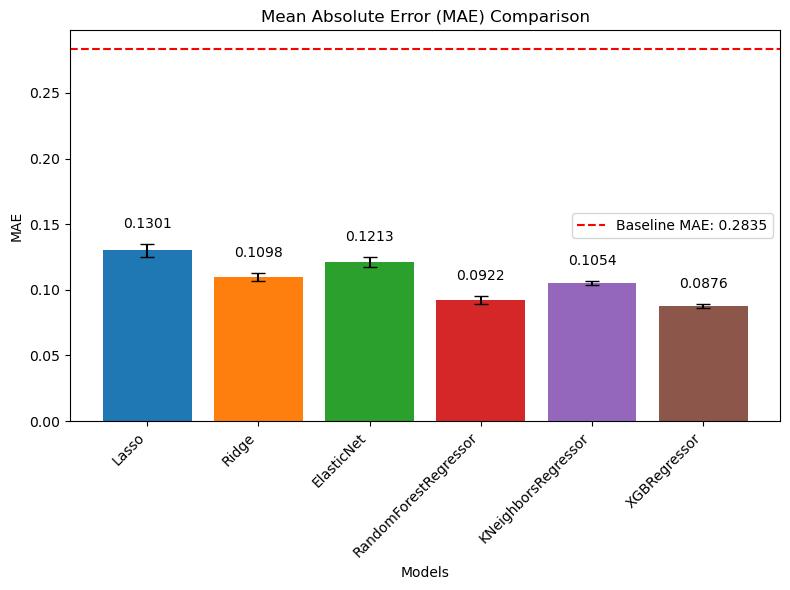

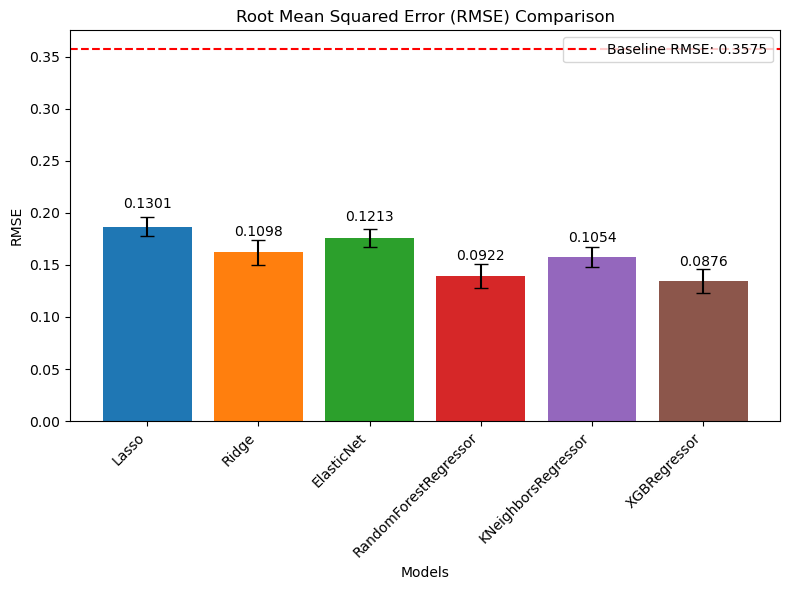

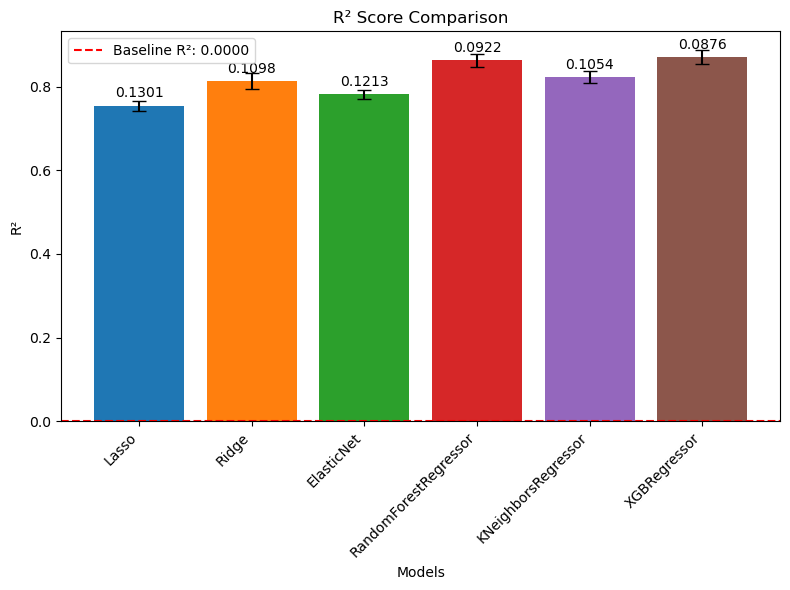

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
model_names = list(results.keys())
means_mae = [results[model]['MAE']['mean_test_score'] if 'MAE' in results[model] else np.nan for model in model_names]
stds_mae = [results[model]['MAE']['std_test_score'] if 'MAE' in results[model] else np.nan for model in model_names]

means_rmse = [results[model]['RMSE']['mean_test_score'] if 'RMSE' in results[model] else np.nan for model in model_names]
stds_rmse = [results[model]['RMSE']['std_test_score'] if 'RMSE' in results[model] else np.nan for model in model_names]

means_r2 = [results[model]['R2']['mean_test_score'] if 'R2' in results[model] else np.nan for model in model_names]
stds_r2 = [results[model]['R2']['std_test_score'] if 'R2' in results[model] else np.nan for model in model_names]

# Baseline values
baseline_metrics = {'MAE': baseline_mae, 'RMSE': baseline_rmse, 'R2': baseline_r2}

# Define colors
colors = plt.cm.tab10(np.arange(len(model_names)))

# Plot MAE
plt.figure(figsize=(8, 6))
for i, model in enumerate(model_names):
    bar = plt.bar(model, means_mae[i], yerr=stds_mae[i], capsize=5, color=colors[i])
    plt.text(
        bar[0].get_x() + bar[0].get_width() / 2,
        bar[0].get_height() + stds_mae[i] + 0.01,
        f'{means_mae[i]:.4f}',
        ha='center',
        va='bottom'
    )
plt.axhline(baseline_mae, color='red', linestyle='--', label=f'Baseline MAE: {baseline_mae:.4f}')
plt.title('Mean Absolute Error (MAE) Comparison')
plt.ylabel('MAE')
plt.xlabel('Models')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/MAE.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# Plot RMSE
plt.figure(figsize=(8, 6))
for i, model in enumerate(model_names):
    bar = plt.bar(model, means_rmse[i], yerr=stds_rmse[i], capsize=5, color=colors[i])
    plt.text(
        bar[0].get_x() + bar[0].get_width() / 2,
        bar[0].get_height() + stds_mae[i] + 0.01, 
        f'{means_mae[i]:.4f}',
        ha='center',
        va='bottom'
    )
plt.axhline(baseline_rmse, color='red', linestyle='--', label=f'Baseline RMSE: {baseline_rmse:.4f}')
plt.title('Root Mean Squared Error (RMSE) Comparison')
plt.ylabel('RMSE')
plt.xlabel('Models')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/RMSE.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# Plot R2
plt.figure(figsize=(8, 6))
for i, model in enumerate(model_names):
    bar = plt.bar(model, means_r2[i], yerr=stds_r2[i], capsize=5, color=colors[i])
    plt.text(
        bar[0].get_x() + bar[0].get_width() / 2,
        bar[0].get_height() + stds_mae[i] + 0.01,
        f'{means_mae[i]:.4f}',
        ha='center',
        va='bottom'
    )
plt.axhline(baseline_r2, color='red', linestyle='--', label=f'Baseline R²: {baseline_r2:.4f}')
plt.title('R² Score Comparison')
plt.ylabel('R²')
plt.xlabel('Models')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/R2.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
xgb_param_grid = {
    'xgb__n_estimators': [100, 300, 500, 700, 1000],
    'xgb__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'xgb__max_depth': [3, 5, 7, 10]
}


In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

def XGBPipeline(X, y, preprocessor, param_grid, scoring):
    """
    Simplified XGBoost pipeline with preprocessing and hyperparameter tuning using GridSearchCV.
    """
    nr_states = 5  # Number of iterations for reproducibility
    test_scores = []
    best_models = []

    print("\nPerforming GridSearchCV...")

    for i in range(nr_states):
        print(f"\nIteration {i+1}")
        
        # Split data into train/validation and test sets
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=42 * i)

        # Define KFold
        kf = KFold(n_splits=4, shuffle=True, random_state=42 * i)

        # Create a full pipeline
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42 * i))])

        # Define GridSearchCV
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring=scoring,
            refit=True,
            cv=kf,
            return_train_score=True,
            n_jobs=-1,
            verbose=1
        )

        # Fit GridSearchCV
        grid.fit(X_other, y_other)

        # Append best models and their scores
        best_models.append(grid.best_estimator_)
        validation_score = -grid.best_score_ if 'neg' in scoring else grid.best_score_
        print('Best model parameters:', grid.best_params_)
        print(f'Validation score for {scoring}:', validation_score)

        # Evaluate on the test set
        y_test_pred = grid.predict(X_test)
        if scoring == 'neg_mean_absolute_error':
            test_mae = mean_absolute_error(y_test, y_test_pred)
            test_scores.append(test_mae)
            print('Test MAE:', test_mae)

        elif scoring == 'neg_root_mean_squared_error':
            test_rmse = root_mean_squared_error(y_test, y_test_pred)
            test_scores.append(test_rmse)
            print('Test RMSE:', test_rmse)

        else:
            test_r2 = r2_score(y_test, y_test_pred)
            test_scores.append(test_r2)
            print('Test R²:', test_r2)

    return best_models, test_scores


In [20]:
# Dictionary to store the best overall models for each scoring metric
best_xgb_model = {s: {'model': None, 'score': float('inf') if 'neg' in s else float('-inf'), 'random_state': None} for s in scorings}

for s in scorings:  
    print(f"Processing metric: {s}")
    best_models, test_scores = XGBPipeline(
        X, y, 
        preprocessor, 
        xgb_param_grid, 
        scoring=s
    )

    # Display and record results
    for i, (model, score) in enumerate(zip(best_models, test_scores)):
        print(f"Iteration {i+1}: Test Score = {score:.4f}")
        print(f"Best Model Parameters: {model.named_steps['xgb'].get_params()}")
        
        # Check if this model is the best for the current scoring metric
        if ('neg' in s and score < best_xgb_model[s]['score']) or ('neg' not in s and score > best_xgb_model[s]['score']):
            print(f"Updating best model for metric {s} with score {score:.4f} (random state: {42 * i})")
            best_xgb_model[s] = {
                'model': model,
                'score': score,
                'random_state': 42 * i  # Compute random state used
            }

# Print the best overall models
print("\nBest Overall Models:")
for metric, info in best_xgb_model.items():
    print(f"Metric: {metric}")
    print(f"  Best Score: {info['score']:.4f}")
    print(f"  Random State: {info['random_state']}")
    print(f"  Best Parameters: {info['model'].named_steps['xgb'].get_params()}")


Processing metric: neg_mean_absolute_error

Performing GridSearchCV...

Iteration 1
Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best model parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 500}
Validation score for neg_mean_absolute_error: 0.0866163685245971
Test MAE: 0.08718449059425488

Iteration 2
Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best model parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 1000}
Validation score for neg_mean_absolute_error: 0.08606843950148238
Test MAE: 0.08812668579474417

Iteration 3
Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best model parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 1000}
Validation score for neg_mean_absolute_error: 0.08960453038994307
Test MAE: 0.08447704437640571

Iteration 4
Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best model parameters: {'xgb__learning_rat

In [43]:
# Save the best overall models to a file
output_file = "../results/best_xgb_model.txt"
with open(output_file, "w") as f:
    f.write("Best Overall Models:\n\n")
    for metric, info in best_xgb_model.items():
        f.write(f"Metric: {metric}\n")
        f.write(f"  Best Score: {info['score']:.4f}\n")
        f.write(f"  Random State: {info['random_state']}\n")
        f.write(f"  Best Parameters:\n")
        for param, value in info['model'].named_steps['xgb'].get_params().items():
            f.write(f"    {param}: {value}\n")
        f.write("\n")

print(f"Best overall models saved to {output_file}")

Best overall models saved to ../results/best_xgb_model.txt


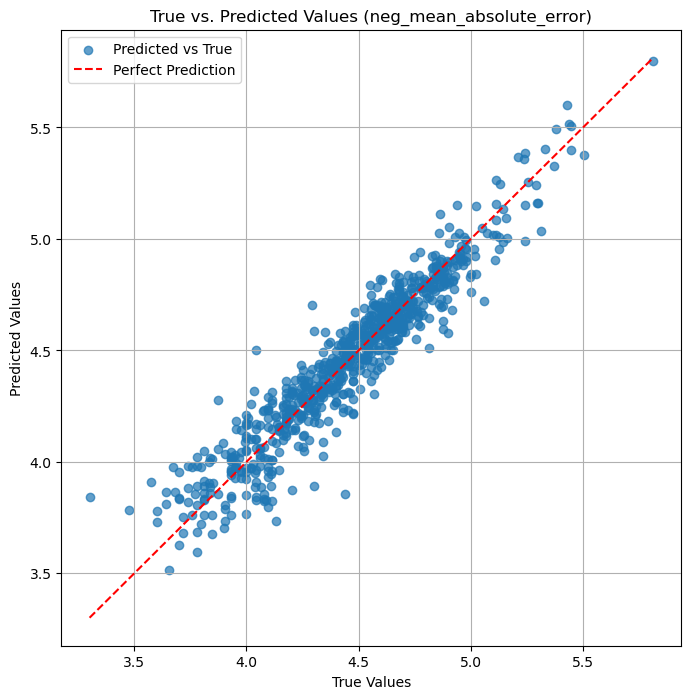

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Generate scatter plot for the best model using a specific metric
metric = 'neg_mean_absolute_error'  # Replace with the desired metric
best_model_info = best_xgb_model[metric]

# Use the corresponding random state to recreate the test set split
random_state = best_model_info['random_state']
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Predict using the best model
best_model = best_model_info['model']
y_test_pred = best_model.predict(X_test)

# Scatter plot of true vs. predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, alpha=0.7, label='Predicted vs True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'True vs. Predicted Values ({metric})')
plt.legend()
plt.grid(True)
plt.savefig('../figures/y_pred_scatter.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


In [23]:
from sklearn.inspection import permutation_importance

# Retrieve the best model (same for all three metrics)
best_model = best_xgb_model['neg_mean_absolute_error']['model']
xgb_model = best_model.named_steps['xgb']

# Compute permutation importance
result = permutation_importance(
    best_model, X_test, y_test, n_repeats=5, random_state=84
)

# Extract and plot top 10 feature importances
importances = result.importances_mean
sorted_indices = importances.argsort()[::-1]  # Sort in descending order

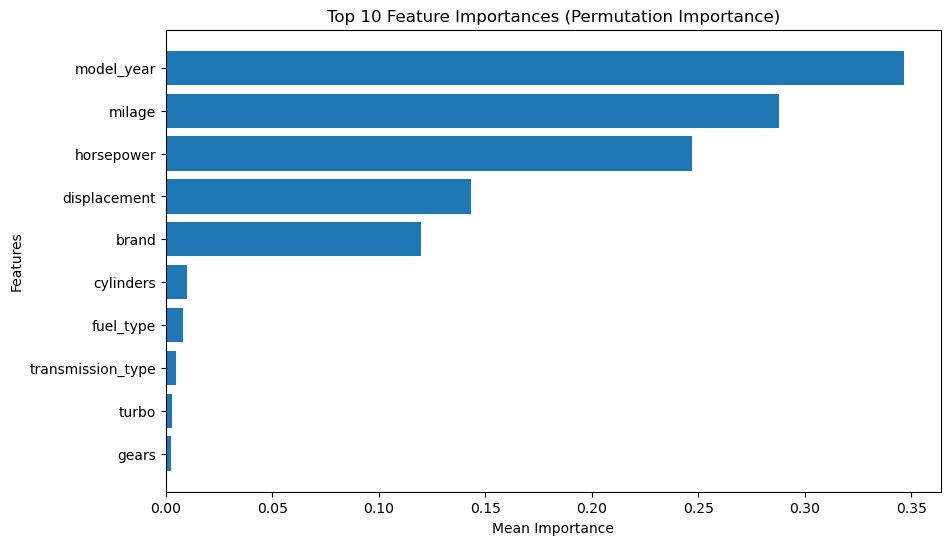

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(
    [X_test.columns[i] for i in sorted_indices[:10]],
    importances[sorted_indices[:10]],
)
plt.xlabel("Mean Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances (Permutation Importance)")
plt.gca().invert_yaxis()
plt.savefig('../figures/permutation_importance.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

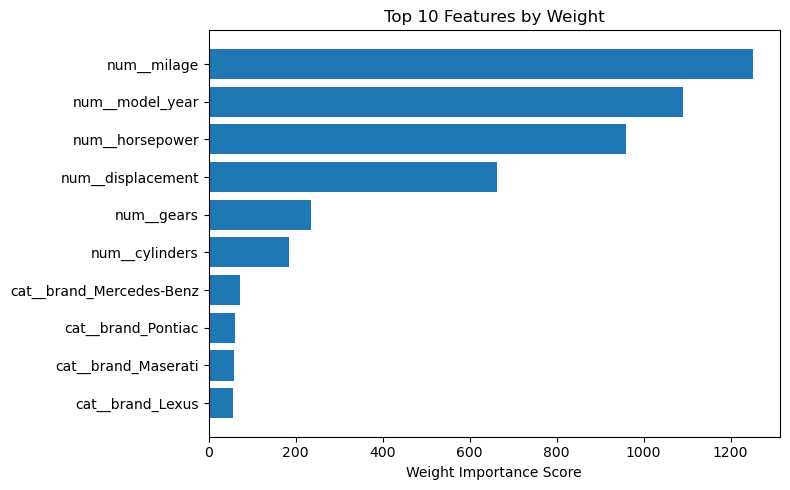

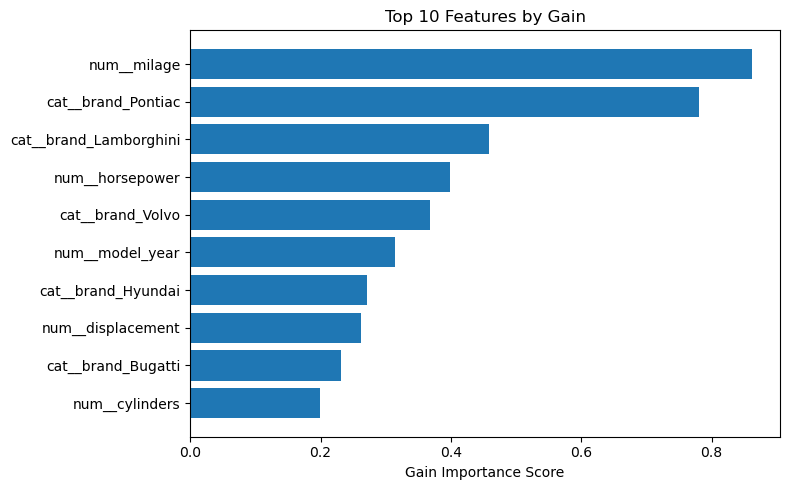

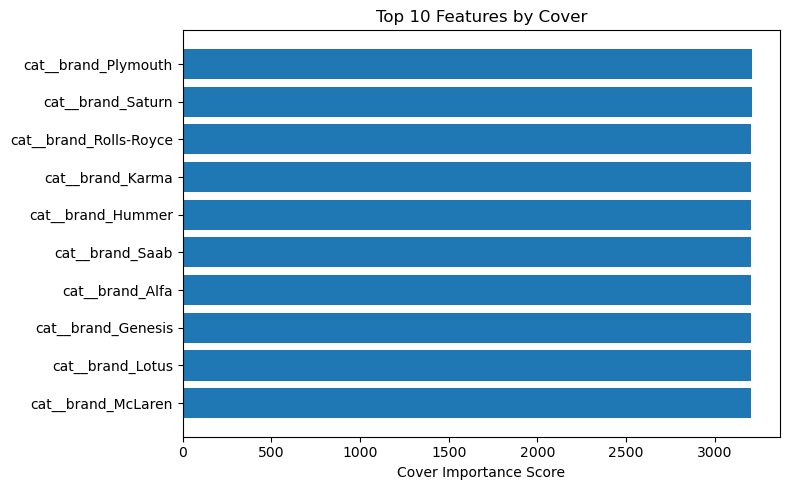

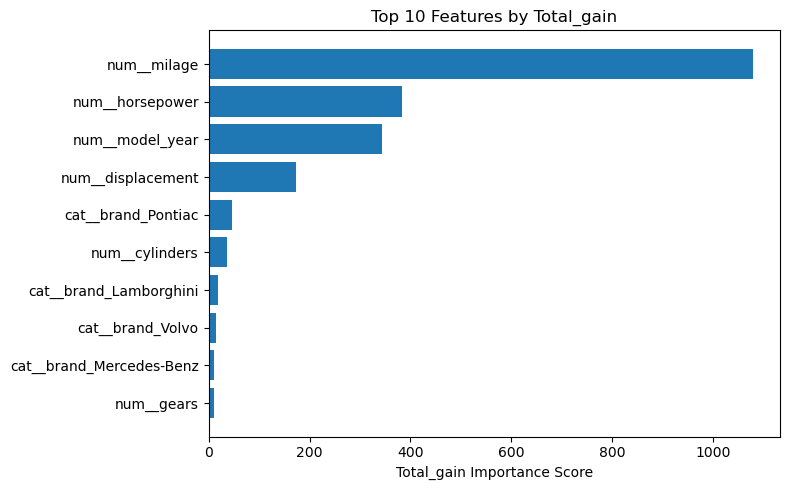

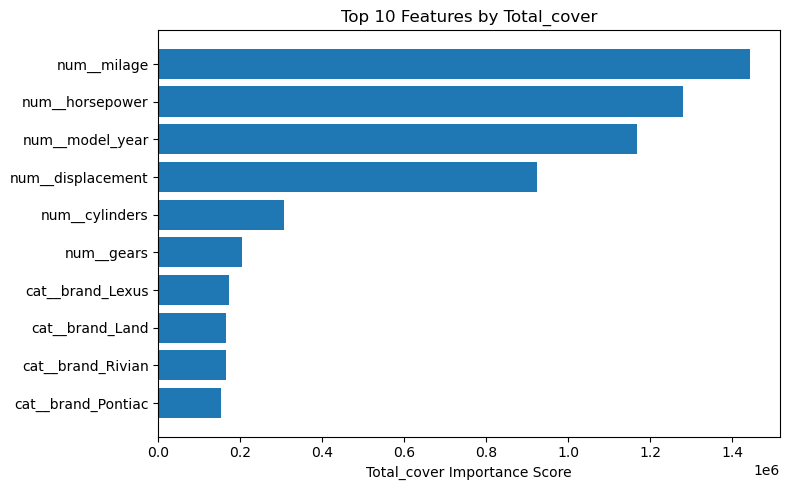

In [37]:
# Extract feature names from the preprocessor
preprocessed_feature_names = preprocessor.get_feature_names_out()

# Map XGBoost feature names (f0, f1, ...) to actual feature names
feature_mapping = {f"f{i}": name for i, name in enumerate(preprocessed_feature_names)}

# Metrics to compute feature importance
booster = xgb_model.get_booster()
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for importance_type in importance_types:
    # Get raw feature importance from the booster
    importance = booster.get_score(importance_type=importance_type)
    
    # Map raw feature names to actual feature names
    mapped_importance = {feature_mapping[k]: v for k, v in importance.items()}
    
    # Convert to a sorted list of (feature, importance)
    sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
    
    # Take the top 10 features
    top_features = sorted_importance[:10]
    feature_names_top, importance_values_top = zip(*top_features)
    
    # Create a bar plot
    plt.figure(figsize=(8, 5))
    plt.barh(feature_names_top, importance_values_top)
    plt.title(f"Top 10 Features by {importance_type.capitalize()}")
    plt.xlabel(f"{importance_type.capitalize()} Importance Score")
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.savefig(f'../figures/{importance_type.capitalize()}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
import os
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# Initialize SHAP
shap.initjs()

# Create SHAP explainer for the model
explainer = shap.TreeExplainer(xgb_model)  # Replace best_model with your trained model

# Compute SHAP values for the test set
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)
X_test_prep = pd.DataFrame(X_test_prep, columns=preprocessor.get_feature_names_out())

# print(explainer.model_input_features)
shap_values = explainer(X_test_prep)  # Pass DataFrame, NOT y_test
output_dir = "../figures"

# Identify indices for top 3 and lowest 3 values in y_test
top_3_indices = np.argsort(y_test)[-3:]  # Indices for top 3 values
lowest_3_indices = np.argsort(y_test)[:3]  # Indices for lowest 3 values

# Combine top and lowest indices
selected_indices = np.concatenate((lowest_3_indices, top_3_indices))

# Loop through the selected indices to create and save plots
for index in selected_indices:
    # Ensure feature values are in the correct shape
    feature_values = X_test_prep.iloc[index].values.round(2)  # Convert to 1D array

    # Generate SHAP force plot
    force_plot = shap.force_plot(
        explainer.expected_value,
        shap_values.values[index],
        feature_values,
        feature_names=X_test_prep.columns.tolist(),
        matplotlib=True,
        show=False
    )

    # Save the plot
    filename = os.path.join(output_dir, f"force_plot_index_{index}.png")
    plt.savefig(f'../figures/force_plot_index_{index}.png', format='png', dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close()  # Close the plot to avoid overlapping
    print(f"Saved SHAP force plot for index {index} to {filename}")



Saved SHAP force plot for index 17 to ../figures/force_plot_index_17.png
Saved SHAP force plot for index 395 to ../figures/force_plot_index_395.png
Saved SHAP force plot for index 325 to ../figures/force_plot_index_325.png
Saved SHAP force plot for index 211 to ../figures/force_plot_index_211.png
Saved SHAP force plot for index 15 to ../figures/force_plot_index_15.png
Saved SHAP force plot for index 591 to ../figures/force_plot_index_591.png


In [27]:
import pandas as pd

my_car = {
    'brand': 'Land',                # Example: 'Toyota'
    'model_year': 2018,           # Example: 2022
    'milage': 62563,               # Example: 15000
    'fuel_type': 'Gasoline',            # Example: 'Gasoline'
    'ext_col': 'Grey',              # Example: 'Blue'
    'int_col': 'White',              # Example: 'Black'
    'accident': None,             # Example: 'None'
    'clean_title': 'Yes',          # Example: 'Yes'
    'horsepower': 380.0,           # Example: 250.0
    'displacement': 3.0,         # Example: 2.5
    'cylinders': 6.0,            # Example: 4.0
    'turbo': False,                # Example: False
    'transmission_type': 'Automatic',    # Example: 'Automatic'
    'gears': 8.0                 # Example: 6.0
}
new_data_df = pd.DataFrame([my_car])
new_data_processed = preprocessor.transform(new_data_df)
prediction = xgb_model.predict(new_data_processed)
original_prediction = np.power(10, prediction)
print(f"Original prediction: {original_prediction}")

Original prediction: [44292.13]
